In [3]:
#Librería para plotear en 3D
from mpl_toolkits.mplot3d import Axes3D

#Incluímos las librerías que vamos a usar
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [21]:
class domain:    

    #El constructor se encarga de hacer el preprocesamiento
    def __init__(self, Lx, Ly, streX, streY, Nx, Ny):       
        self.Nx = Nx                                        #Número de puntos desde 0 hasta Nx
        self.x = self.RG(streX, Lx, Nx)                     #Creo un vector que va desde el 0 hasta Lx con Nx+1 divisiones
        self.Lx = Lx

        self.Ny = Ny                                        #Número de puntos desde 0 hasta Ny
        self.y = self.RG(streY, Ly, Ny)                     #Creo un vector que va desde el 0 hasta Ly con Ny+1 divisiones
        self.Ly = Ly


        self.X, self.Y = np.meshgrid(self.x, self.y)

        fig = plt.figure()                                           #Creo una ventana
        ax = fig.add_subplot(111)                                    #A la ventana le añado un plano en 2d

        for i in range(0,self.Nx+1):
            ax.plot(self.X[:,i], self.Y[:,0], color='k')

        for i in range(0,self.Nx+1):
            ax.plot(self.X[0,:], self.Y[i,:], color='k')

        #ax.plot(self.X, self.Y, color = 'k', ls='None', marker='.')  #Dentro del plano creado grafico 
        plt.xlim([0, Lx])
        plt.ylim([0, Ly])
        plt.title('Grid of the domain')
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.show

        
    #Con esa función defino las coordenadas para hacer un enmallado no uniforme
    def RG(self, stretch, L, N):
        grid = np.zeros(N+1)
        tanGamma = np.tanh(stretch)

        for i in range(0, N+1):
            epsilon = 1 - 2*(i)/(N)
            grid[i] = (1 - np.tanh(stretch*epsilon)/tanGamma)*0.5*L
        return grid

    #En esa función se busca la convergencia de PPE
    def pressure(self, P2, Vel):
        deltaX1 = (self.x[1:-1]-self.x[:-2])
        deltaX2 = (self.x[2:]-self.x[1:-1])
        deltaY1 = (self.y[1:-1]-self.y[:-2])
        deltaY2 = (self.y[2:]-self.y[1:-1])

        for n in range(50):
            P1 = P2.copy()
            P2 [1:-1,1:-1] = ((0.5*(deltaY1**2 + deltaY2**2))*(P1[1:-1, 2:]+P1[1:-1,:-2]) + 
                            (0.5*(deltaX1**2 + deltaX2**2))*(P1[2:,1:-1]+P1[:-2,1:-1])) \
                            /(2*(0.5*((deltaX1)**2 + (deltaX2)**2) + 0.5*((deltaY1)**2 + (deltaY2)**2))) + \
                            Vel[1:-1,1:-1]
            
            #Condiciones de frontera
            P2[:,0] = P2[:,1]   #dp/dx=0 en x=0
            P2[:,-1] = P2[:,-2] #dp/dx=0 en x=Lx
            P2[0,:] = P2[1,:]   #dp/dy=0 en y=0
            P2[-1,:] = 0        #p=0 y=Ly - Presión atmosférica en la superficie

        return P2
    

    def constantes(self, eta, rho):
        #Definición de todas las constantes
        deltaX1 = (self.x[1:-1]-self.x[:-2])
        deltaX2 = (self.x[2:]-self.x[1:-1])
        deltaY1 = (self.y[1:-1]-self.y[:-2])
        deltaY2 = (self.y[2:]-self.y[1:-1])

        alfa = eta*self.dt/(0.5*(deltaX1**2 + deltaX2**2))
        beta = eta*self.dt/(0.5*(deltaY1**2 + deltaY2**2))
        C = self.dt/(rho*(deltaX1 + deltaX2))
        D = self.dt/(rho*(deltaY1 + deltaY2))
        E = self.dt/(deltaX1)
        F = self.dt/(deltaY1)
        R = -rho*0.5**2*((deltaX1**2 + deltaX2**2)*(deltaY1**2 + deltaY2**2)) \
            /((deltaX1**2 + deltaX2**2) + (deltaY1**2 + deltaY2**2))

        return alfa, beta, C, D, E, F, R 
    
    def VelPres(self, u2, v2, R, Vel):
        deltaX1 = (self.x[1:-1]-self.x[:-2])
        deltaX2 = (self.x[2:]-self.x[1:-1])
        deltaY1 = (self.y[1:-1]-self.y[:-2])
        deltaY2 = (self.y[2:]-self.y[1:-1])

        Vel[1:-1,1:-1] = R*(1/self.dt*((u2[1:-1,2:]-u2[1:-1,:-2])/(deltaX1 + deltaX2) + (v2[2:, 1:-1]-v2[:-2,1:-1])/(deltaY1 + deltaY2)) -
                            ((u2[1:-1,2:]-u2[1:-1,:-2])/(deltaX1 + deltaX2))**2 - 
                            2*(u2[2:,1:-1]-u2[:-2,1:-1])/(deltaY1 + deltaY2)*(v2[1:-1,2:]-v2[1:-1,:-2])/(deltaX1 + deltaX2) -
                            ((v2[2:, 1:-1]-v2[:-2,1:-1])/(deltaY1 + deltaY2))**2)
        return Vel

    def velocity(self, T, dt, eta, rho, lidVel):
        self.Re = lidVel*self.Ly/eta                          #Este Reynold está incompleto. En el plotter lo multiplico por la velocidad
        self.Nt = int(T/dt)                            #Número de puntos desde 0 hasta Nt
        self.t = np.linspace(0, T, self.Nt+1)          #Creo un vector que va desde el 0 hasta T con Nt+1 divisiones
        self.dt = self.t[1]-self.t[0]                  #Chequeo del dt, para que coincida

        #Initial conditions: U, V, P = 0 at time t=0
        u2 = np.zeros((self.Nx+1, self.Ny+1))
        v2 = np.zeros((self.Nx+1, self.Ny+1))
        P2  = np.zeros((self.Nx+1, self.Ny+1))
        Vel = np.zeros((self.Nx+1, self.Ny+1))

        #Constante para definir todas las variables
        alfa, beta, C, D, E, F, R = self.constantes(eta, rho)

        Vel = self.VelPres(u2, v2, R, Vel)

        for n in range(1, self.Nt):
            u1 = u2.copy()
            v1 = v2.copy()

            #Uso el corrector de la ecuación de continuidad
            Vel = self.VelPres(u2, v2, R, Vel)
            P2 = self.pressure(P2, Vel)

            u2[1:-1,1:-1] = u1[1:-1,1:-1] -\
                            E*u1[1:-1,1:-1]*(u1[1:-1,1:-1] - u1[1:-1,:-2]) - \
                            F*v1[1:-1,1:-1]*(u1[1:-1,1:-1]-u1[:-2,1:-1]) - \
                            C*(P2[1:-1, 2:]-P2[1:-1,:-2]) +\
                            alfa*(u1[1:-1,2:] - 2*u1[1:-1,1:-1] + u1[1:-1,:-2]) +\
                            beta*(u1[2:,1:-1] - 2*u1[1:-1,1:-1] + u1[:-2,1:-1])
            
            v2[1:-1,1:-1] = v1[1:-1,1:-1] -\
                            E*u1[1:-1,1:-1]*(v1[1:-1,1:-1] - v1[1:-1,:-2]) - \
                            F*v1[1:-1,1:-1]*(v1[1:-1,1:-1]-v1[:-2,1:-1]) - \
                            D*(P2[2:,1:-1]-P2[:-2,1:-1]) +\
                            alfa*(v1[1:-1,2:] - 2*v1[1:-1,1:-1] + v1[1:-1,:-2]) +\
                            beta*(v1[2:,1:-1] - 2*v1[1:-1,1:-1] + v1[:-2,1:-1])
            
            #Después del primer paso temporal entran en vigencia las condiciones de frontera para la velocidad
            u2[:,0] = 0 #Condición de no deslizamientos
            v2[:,0] = 0
            u2[:,-1] = 0
            v2[:,-1] = 0
            u2[-1,:] = lidVel
            v2[-1,:] = 0
            u2[0,:] = 0   #La tapa que se mueve
            v2[0,:] = 0

        #Luego de solucionar el caso, hago que las matrices sean atributos de la clase 
        self.u2 = u2
        self.v2 = v2
        self.P2 = P2

        np.savetxt('U_Re{:.0f}.txt'.format(self.Re), self.u2)
        np.savetxt('V_Re{:.0f}.txt'.format(self.Re), self.v2)
        np.savetxt('P_Re{:.0f}.txt'.format(self.Re), self.P2)
        np.savetxt('X{:.0f}.txt'.format(self.Re), self.X)
        np.savetxt('Y{:.0f}.txt'.format(self.Re), self.Y)

    def streams(self):
        Unix = np.linspace(self.x.min(), self.x.max(), 30)
        Uniy = np.linspace(self.y.min(), self.y.max(), 30)

        xi, yi = np.meshgrid(Unix,Uniy)

        #then, interpolate your data onto this grid:
        Flatx = self.X.flatten()
        Flaty = self.Y.flatten()
        Flatu = self.u2.flatten()
        Flatv = self.v2.flatten()
        
        Interu2 = griddata((Flatx, Flaty), Flatu, (xi,yi), method='linear')
        Interv2 = griddata((Flatx, Flaty), Flatv, (xi,yi), method='linear')

        return Unix, Uniy, Interu2, Interv2

    def plotter(self):
        
        Unix, Uniy, Interu2, Interv2 = self.streams()
        
        fig = plt.figure()
        plt.contourf(self.X, self.Y, self.P2, cmap = 'turbo')
        plt.colorbar()
        Contorno = plt.contour(self.X, self.Y, self.P2, colors='black', linestyles='dashed')  
        plt.clabel(Contorno, inline = 1, fontsize=8)

        plt.streamplot(Unix, Uniy, Interu2, Interv2, density = 0.4, color = 'black')
        plt.title('$Simulation~at~t={:.3f}~s~and~Re={:.1f}$'.format(self.t[-1], self.Re))
        plt.xlabel('$x[m]$')
        plt.ylabel('$y[m]$')
        plt.xlim([0, self.Lx])
        plt.ylim([0, self.Ly])


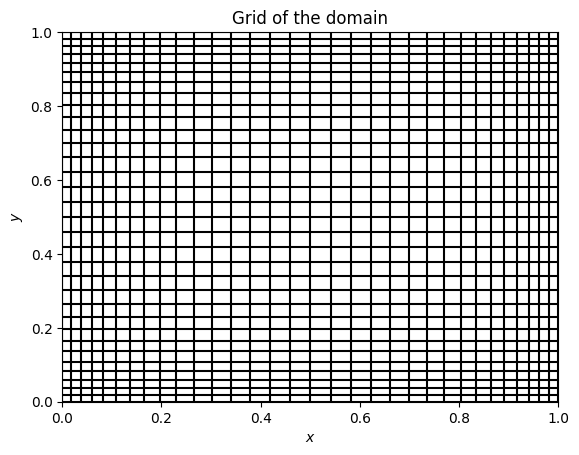

In [22]:
#Hyperbolic tangent type clustering
Lx = 1
Ly = 1
streX = 1.0
streY = 1.0
Nx = 32
Ny = 32

cavity = domain(Lx, Ly, streX, streY, Nx, Ny)

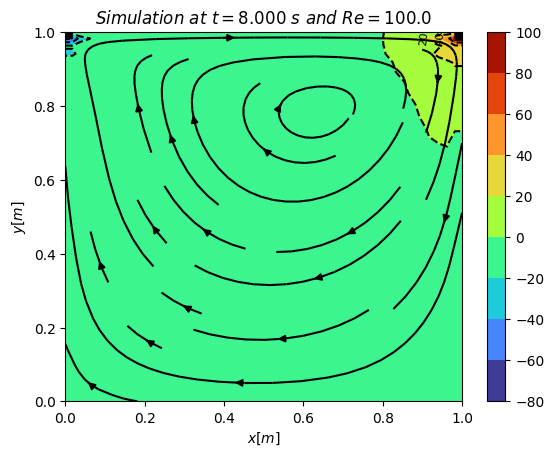

In [23]:
T = 8.0
dt = 0.0001
rho = 1
nu = 0.1
eta = (nu/rho)
lidVel = 10
cavity.velocity(T, dt, eta, rho, lidVel)
cavity.plotter()

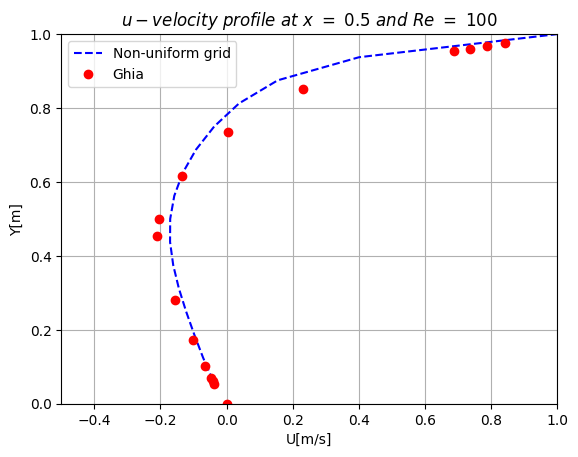

In [84]:
#Función para hacer postproceso
def postPro(X, Y, U, V, vectorX, vectorY):

    #Convierto la malla en un vector, para poder interpolar
    flatX = X.flatten()
    flatY = Y.flatten()
    flatU = U.flatten()
    flatV = V.flatten()

    InterU = griddata((flatX, flatY), flatU, (vectorX,vectorY), method='cubic')
    InterV = griddata((flatX, flatY), flatV, (vectorX,vectorY), method='cubic')

    return InterU, InterV

#Importamo los archivos almacenados
filename01 = 'P_Re100.txt'
filename02 = 'U_Re100.txt'
filename03 = 'V_Re100.txt'
filename04 = 'X100.txt'
filename05 = 'Y100.txt'
filename06 = 'perfilU_Re100.txt'

#Se almacenan en matrices
pressureField = np.loadtxt(filename01, delimiter=' ', skiprows=1, dtype=float)
uField = np.loadtxt(filename02, delimiter=' ', skiprows=1, dtype=float)
vField = np.loadtxt(filename03, delimiter=' ', skiprows=1, dtype=float)
X = np.loadtxt(filename04, delimiter=' ', skiprows=1, dtype=float)
Y = np.loadtxt(filename05, delimiter=' ', skiprows=1, dtype=float)
ghia = np.loadtxt(filename06, delimiter=' ', skiprows=1, dtype=float)

#Quiero conocer el perfil de velocidad en el centro
vectorX = np.ones(17)*0.5
vectorY = np.linspace(0, Ly, 17)

InterU, InterV = postPro(X, Y, uField, vField, vectorX, vectorY)

normU = InterU/lidVel
fig, ax = plt.subplots()
ax.plot(normU, vectorY, '--b', label ='Non-uniform grid')
ax.plot(ghia[:,1], ghia[:,0], 'or', label = 'Ghia')
ax.set_xlim([-0.5, 1])
ax.set_ylim([0, Ly])
ax.grid()
ax.set_xlabel('U[m/s]')
ax.set_ylabel('Y[m]')
ax.set_title('$u-velocity~profile~at~x~=~0.5~and~Re~=~100$')
ax.legend(loc ="upper left")
